In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sco

from tensorflow import keras 

plt.style.use('fivethirtyeight')
np.random.seed(777)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
TOLERANCE = 1e-10
directory = '../dataset/'
stocks = ['AMD.csv', 'FB.csv', 'TSLA.csv', 'TWTR.csv', 'MONDY.csv']
stocks = [directory + s for s in stocks]
stocks

['../dataset/AMD.csv',
 '../dataset/FB.csv',
 '../dataset/TSLA.csv',
 '../dataset/TWTR.csv',
 '../dataset/MONDY.csv']

In [3]:
dfs = [pd.read_csv(s)[['Date', 'Close']] for s in stocks]
for df in dfs:
    df.Date = pd.to_datetime(df.Date)
dfs[0].head()

Date  Close
0 2018-05-23  13.10
1 2018-05-24  13.41
2 2018-05-25  13.54
3 2018-05-29  13.36
4 2018-05-30  13.82

Let’s transform the data a little bit to make it easier to work with.

In [4]:
from functools import reduce
data = reduce(lambda left,right: pd.merge(left,right,on='Date'), dfs).set_index('Date')
data.columns = ['AMD','FB','TSLA','TWTR','MONDY']
data.head()

AMD          FB       TSLA       TWTR      MONDY
Date                                                              
2018-07-13  16.270000  207.320007  63.773998  44.490002  56.889999
2018-07-16  16.580000  207.229996  62.020000  44.259998  56.639999
2018-07-17  16.870001  209.990005  64.538002  44.709999  57.730000
2018-07-18  16.850000  209.360001  64.769997  43.340000  57.810001
2018-07-19  16.709999  208.089996  64.045998  43.439999  52.380001

Let’s first look at how the price of each stock has evolved within the given time frame.

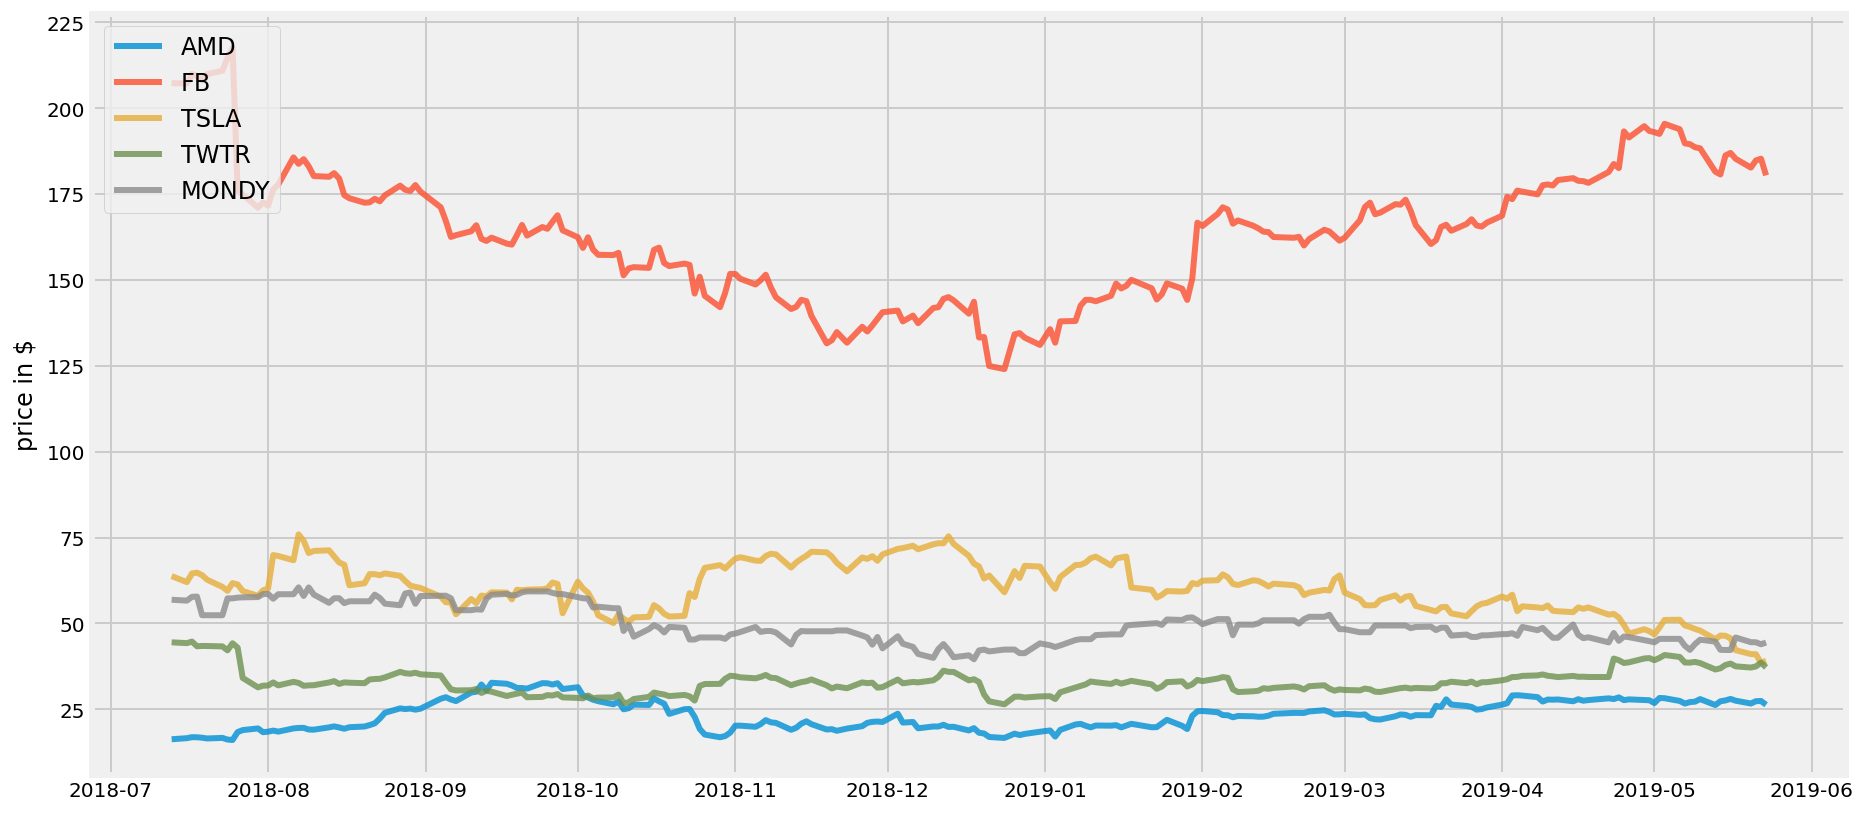

In [5]:
plt.figure(figsize=(14, 7))
for c in data.columns.values:
    plt.plot(data.index, data[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')
plt.show()

Another way to plot this is plotting daily returns (percent change compared to the day before). By plotting daily returns instead of actual prices, we can see the stocks’ volatility.

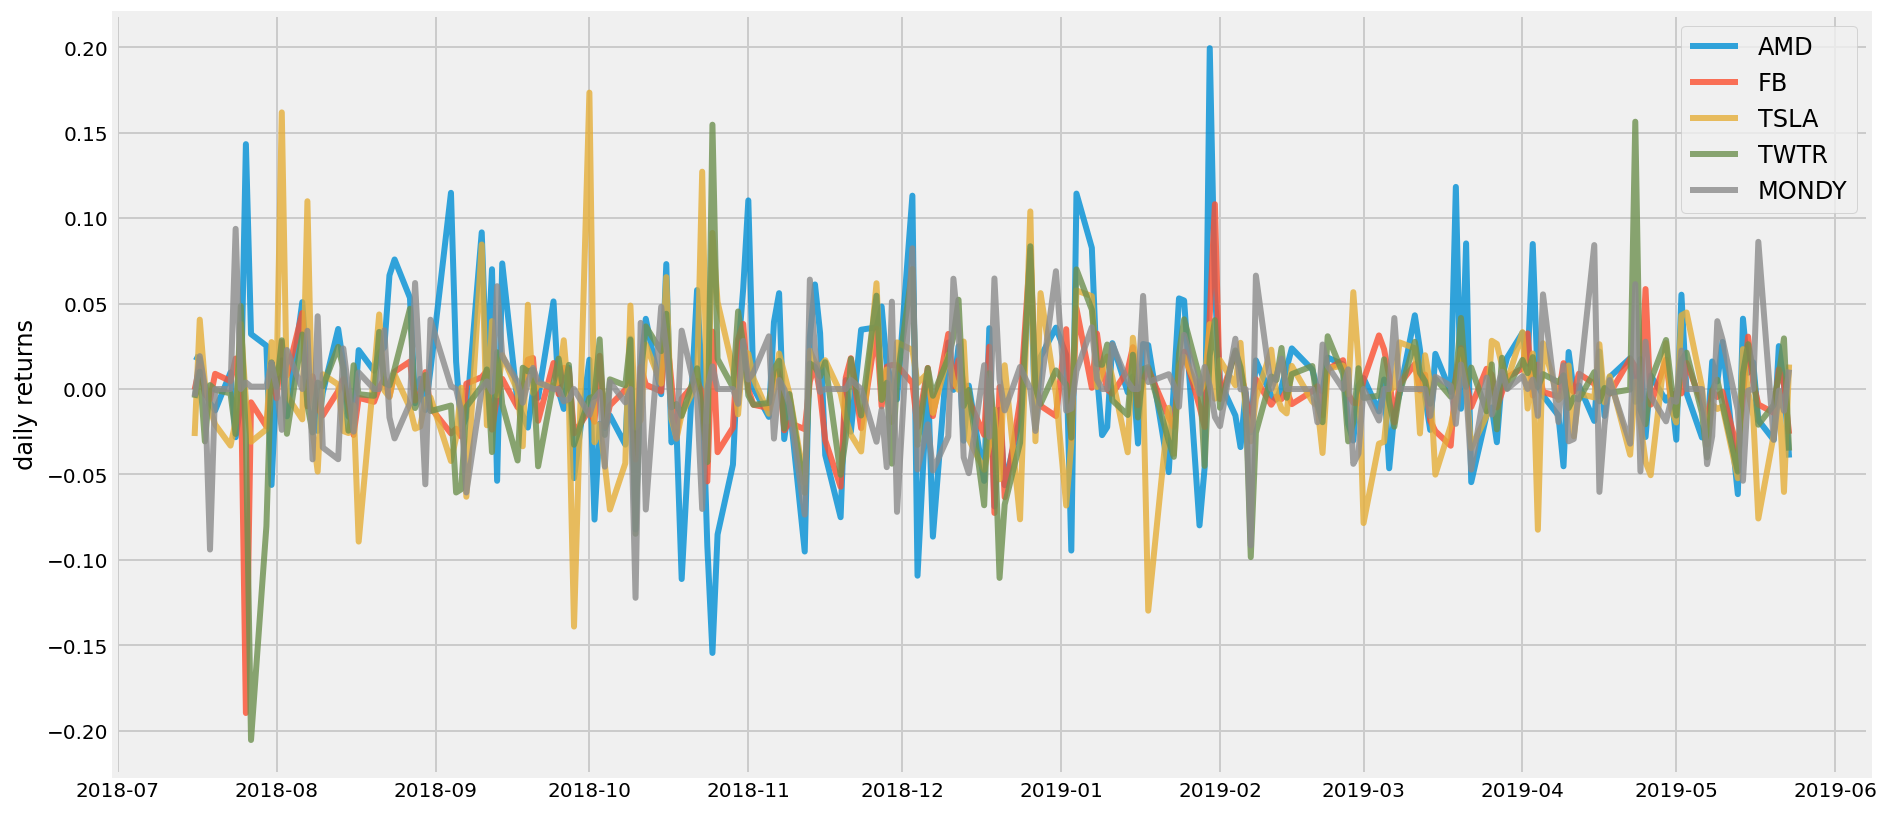

In [6]:
returns = data.pct_change().iloc[1:, :]

plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')
plt.show()

## Random Portfolios Generation

We have 5 stocks in our portfolio. One decision we have to make is how we should allocate our budget to each of stock in our portfolio. If our total budget is 1, then we can decide the weights for each stock, so that the sum of weights will be 1. And the value for weights will be the portion of budget we allocate to a specific stock. For example, if weight is 0.5 for Amazon, it means that we allocate 50% of our budget to Amazon.

Let’s define some functions to simulate random weights to each stock in the portfolio, then calculate the portfolio’s overall annualised returns and annualised volatility.

- `portfolio_annualised_performance` function will calculate the returns and volatility, and to make it as an annualised calculation I take into account 252 as the number of trading days in one year. - - --

- `random_portfolios` function will generate portfolios with random weights assigned to each stock, and by giving num_portfolios argument, you can decide how many random portfolios you want to generate.

In [7]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(5)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

### Portfolio standard deviation

The calculation for portfolio’s volatility in `portfolio_annualised_performance` function is derived from the standard formula for portfolio standard deviation:

$$\sigma_p = \sqrt{w_1^2\sigma_1^2+w_2^2\sigma_2^2+2w_1w_2 \sigma_{1,2}}$$

This formula can be [simplified](https://medium.com/python-data/assessing-risks-and-return-with-probabilities-of-events-with-python-c564d9be4db4) if we make use of matrix notation.


$$\begin{align}
  \sigma_p^2 &= \begin{bmatrix} w_{1} & w_{2} \end{bmatrix}\begin{bmatrix} \sigma_{1}^2 & \sigma_{1,2} \\ \sigma_{2,1} & \sigma_{2}^2 \end{bmatrix}\begin{bmatrix} w_{1} \\ w_{2} \end{bmatrix} \\
  &= \begin{bmatrix}w_1\sigma_1^2+w_2\sigma_{2,1} &w_1\sigma_{1,2}+w_2\sigma_2^2\end{bmatrix}\begin{bmatrix} w_{1} \\ w_{2} \end{bmatrix} \\
  &= w_1^2\sigma_1^2+w_1w_2 \sigma_{2,1}+w_1w_2 \sigma_{1,2}+w_2^2\sigma_2^2 \\
  &= w_1^2\sigma_1^2+w_2^2\sigma_2^2+2w_1w_2 \sigma_{1,2} 
\end{align}$$

With the above matrix calculation, we get the part inside the square root in the original formula. Now, all we need to do is put them inside the square root. Same as the annualised return, I took into account of 252 trading days (in this case, the square root of 252) to calculate the annualised standard deviation of a portfolio.

### Sharpe ratio

In order to understand the Sharpe ratio, it is essential to understand the broader concept of risk-adjusted return. Risk-adjusted return refines an investment’s return by measuring how much risk is involved in producing that return, which is generally expressed as a number or rating. There could be a number of different methods of expressing risk-adjusted return, and the Sharpe ratio is one of them.

The ratio describes how much excess return you are receiving for the extra volatility that you endure for holding a riskier asset. The Sharpe ratio can be expressed as:

$$s=\frac{\bar{r}_p-r_t}{\sigma_p}$$

where $\hat{r}_p$ is the expected portfolio return, $r_t$ is the risk free rate, and $\sigma_p$ is the portfolio standard deviation. 

There are some criticisms on how the Sharpe ratio uses the standard deviation of returns as a denominator, which assumes the normal distribution of the returns. However, more often thans not, the returns on financial assets tend to deviate from a normal distribution and may make interpretations of the Sharpe ratio misleading. It is for this reason that there are other methods which adjust or modify the original Sharpe ratio. But it is a more advanced topic, and I will stick to the traditional Sharpe ratio for this post.

Let’s get the needed argument values for our functions. You can easily get daily returns by calling `pct_change` on the data frame with the price data. And the mean daily returns, the covariance matrix of returns are needed to calculate portfolio returns and volatility. We will generate 25,000 random portfolios. Finally, the risk-free rate has been taken from U.S. Department of The Treasury. The rate of 1.78% is the 52week treasury bill rates at the start of 2018. 

In [8]:
mean_daily_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0178

Let me briefly explain what below function is doing. First, it generates random portfolio and gets the results (portfolio returns, portfolio volatility, portfolio Sharpe ratio) and weights for the corresponding result. Then by locating the one with the highest Sharpe ratio portfolio, it displays maximum Sharpe ratio portfolio as red star sign. And does similar steps for minimum volatility portfolio, and displays it as a green star on the plot. All the randomly generated portfolios will be also plotted with colour map applied to them based on the Sharpe ratio. Bluer, higher the Sharpe ratio.

And for these two optimal portfolios, it will also show how it allocates the budget within the portfolio.

In [9]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=data.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*50)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*50)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.6
Annualised Volatility: 0.58


              AMD   FB  TSLA  TWTR  MONDY
allocation  78.44  0.3  2.82  3.01  15.43
--------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: -0.08
Annualised Volatility: 0.29


             AMD     FB   TSLA  TWTR  MONDY
allocation  7.84  47.66  14.11  1.36  29.03


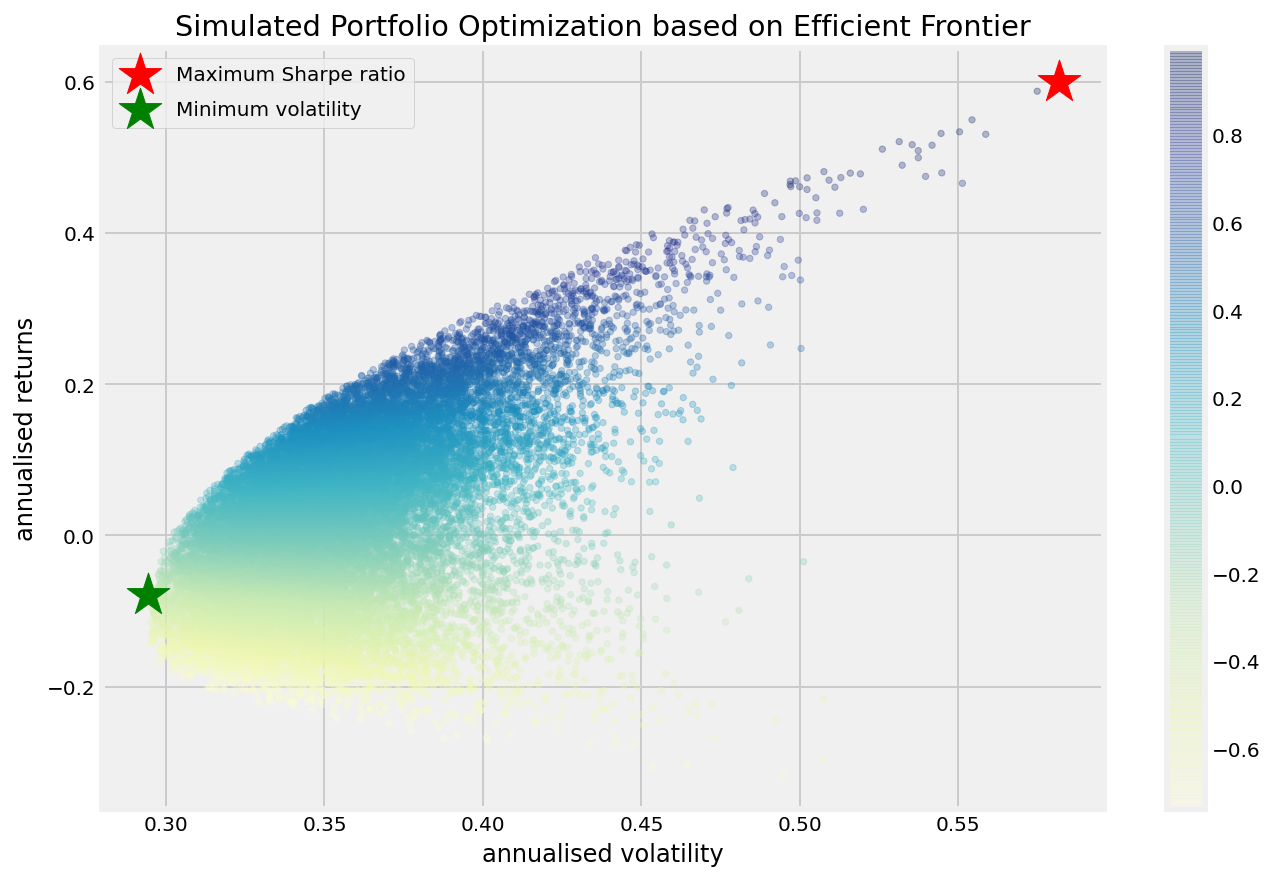

In [10]:
display_simulated_ef_with_random(mean_daily_returns, cov_matrix, num_portfolios, risk_free_rate)

For minimum risk portfolio, we can see that almost half of our budget is allocated to FB. If you take another look at the daily return plot from earlier, you can see that FB is the least volatile stock, so allocating a large percentage to it for minimum risk portfolio makes intuitive sense.

If we are willing to take higher risk for higher return, one that gives us the best risk-adjusted return is the one with maximum Sharpe ratio. In this scenario, we are allocating a significant portion to AMD, which are quite volatile stocks from the previous plot of daily returns.

## Efficient Frontier

From the plot of the randomly simulated portfolios, we can see it forms a shape of an arch line on the top of clustered blue dots. This line is called efficient frontier. Why is it efficient? Because points along the line will give you the lowest risk for a given target return. All the other dots right to the line will give you higher risk with same returns. If the expected returns are the same, why would you take an extra risk when there’s an option with lower risk?

The way we found the two kinds of optimal portfolio above was by simulating many possible random choices and pick the best ones (either minimum risk or maximum risk-adjusted return). We can also implement this by using Scipy’s optimize function.

Scipy’s optimize function is doing the optimization task when given what to optimize, and what are constraints and bounds.

Below functions are to get the maximum Sharpe ratio portfolio. In Scipy’s optimize function, there’s no ‘maximize’, so as an objective function you need to pass something that should be minimized. That is why the first “neg_sharpe_ratio” is computing the negative Sharpe ratio. Now we can use this as our objective function to minimize. In “max_sharpe_ratio” function, you first define arguments (this should not include the variables you would like to change for optimisation, in this case, “weights”).

In [11]:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

The above constraint is saying that sum of x should be equal to 1. You can think of the ‘fun’ part construction as ‘1’ on the right side of equal sign has been moved to the left side of the equal sign.

`np.sum(x) == 1 has become np.sum(x)-1`

And what does this mean? It simply means that the sum of all the weights should be equal to 1. You cannot allocate more than 100% of your budget in total.

“bounds” is giving another limit to assign random weights, by saying any weight should be inclusively between 0 and 1. You cannot give minus budget allocation to a stock or more than 100% allocation to a stock.

In [12]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, 
                          num_assets*[1./num_assets,], 
                          args=args,
                          method='SLSQP', 
                          bounds=bounds, 
                          constraints=constraints)
    return result

We can also define an optimising function for calculating minimum volatility portfolio. This time we really do minimise objective function. What do we want to minimise? We want to minimise volatility by trying different weights. “constraints” and “bounds” are same as the above.

In [13]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, 
                          num_assets*[1./num_assets,], 
                          args=args,
                          method='SLSQP', 
                          bounds=bounds, 
                          constraints=constraints)

    return result

As I already mentioned above we can also draw a line which depicts where the efficient portfolios for a given risk rate should be. This is called “efficient frontier”. Below I define other functions to compute efficient frontier. The first function “efficient_return” is calculating the most efficient portfolio for a given target return, and the second function “efficient_frontier” will take a range of target returns and compute efficient portfolio for each return level.

In [14]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, 
                          num_assets*[1./num_assets,], 
                          args=args, 
                          method='SLSQP', 
                          bounds=bounds, 
                          constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

Let’s try to plot the portfolio choices with maximum Sharpe ratio and minimum volatility also with all the randomly generated portfolios. But this time, we are not picking the optimal ones from the randomly generated portfolios, but we are actually calculating by using Scipy’s ‘minimize’ function. And the below function will also plot the efficient frontier line.

In [15]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=data.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*50)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*50)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)
    plt.savefig('portfolio-optimization.png')

--------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.81
Annualised Volatility: 0.71


              AMD   FB  TSLA  TWTR  MONDY
allocation  100.0  0.0   0.0   0.0    0.0
--------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: -0.11
Annualised Volatility: 0.29


            AMD     FB   TSLA  TWTR  MONDY
allocation  5.6  46.78  16.17   0.0  31.45


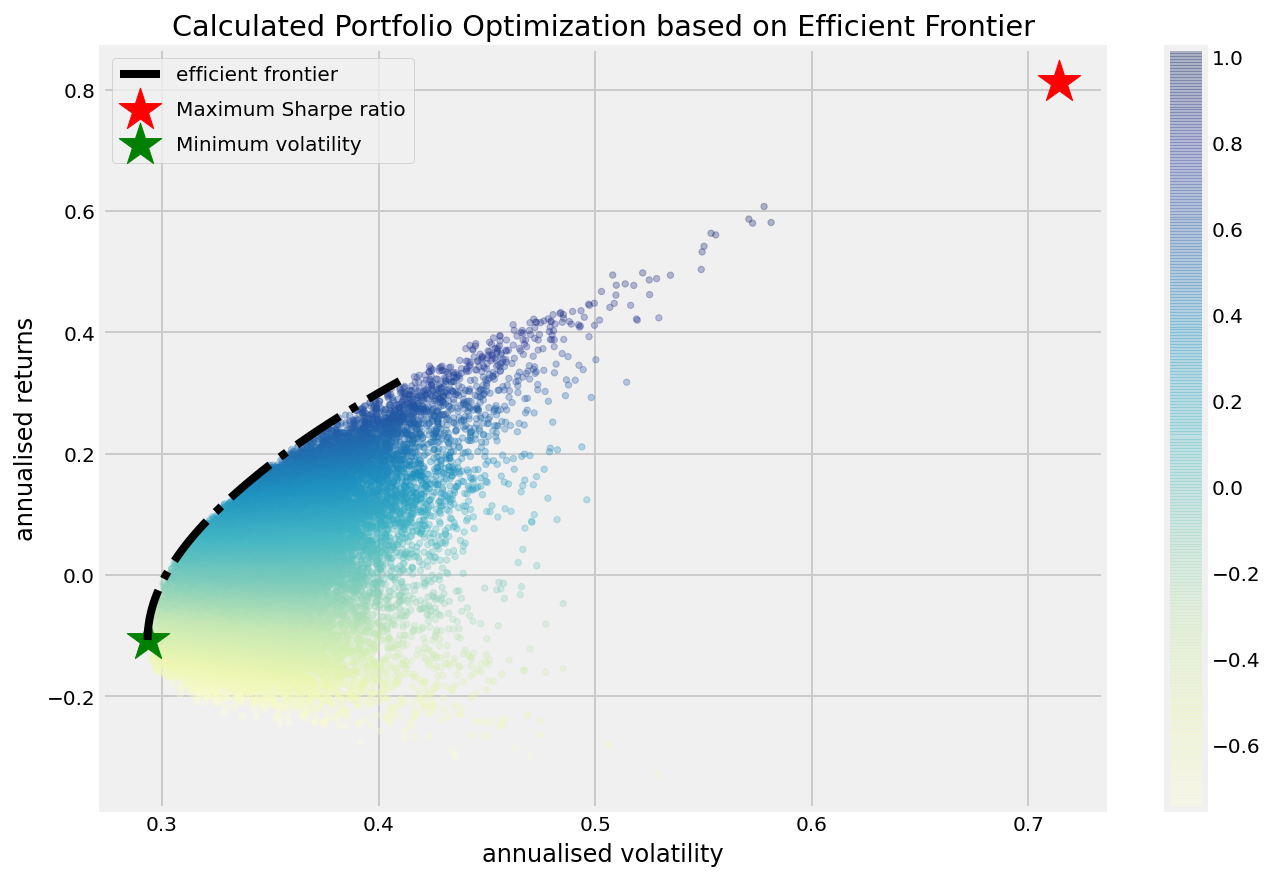

In [16]:
display_calculated_ef_with_random(mean_daily_returns, cov_matrix, num_portfolios, risk_free_rate)

We have almost the same result as what we have simulated by picking from the randomly generated portfolios. The slight difference is that the Scipy’s “optimize” function has allocated all budget at AMD on maximum Sharpe ratio portfolio, while one we chose from the randomly generated samples has 78.44% of allocation for AMD. There are some differences in the decimal places but more or less same.

Instead of plotting every randomly generated portfolio, we can plot each individual stocks on the plot with the corresponding values of each stock’s annual return and annual risk. This way we can see and compare how diversification is lowering the risk by optimising the allocation.

In [17]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=data.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print ("-"*50)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*50)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    print ("-"*50)
    print ("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(data.columns):
        print (txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
    print ("-"*50)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(data.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

--------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.81
Annualised Volatility: 0.71


              AMD   FB  TSLA  TWTR  MONDY
allocation  100.0  0.0   0.0   0.0    0.0
--------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: -0.11
Annualised Volatility: 0.29


            AMD     FB   TSLA  TWTR  MONDY
allocation  5.6  46.78  16.17   0.0  31.45
--------------------------------------------------
Individual Stock Returns and Volatility

AMD : annuaised return 0.81 , annualised volatility: 0.71
FB : annuaised return -0.08 , annualised volatility: 0.39
TSLA : annuaised return -0.38 , annualised volatility: 0.61
TWTR : annuaised return -0.06 , annualised volatility: 0.54
MONDY : annuaised return -0.16 , annualised volatility: 0.5
--------------------------------------------------


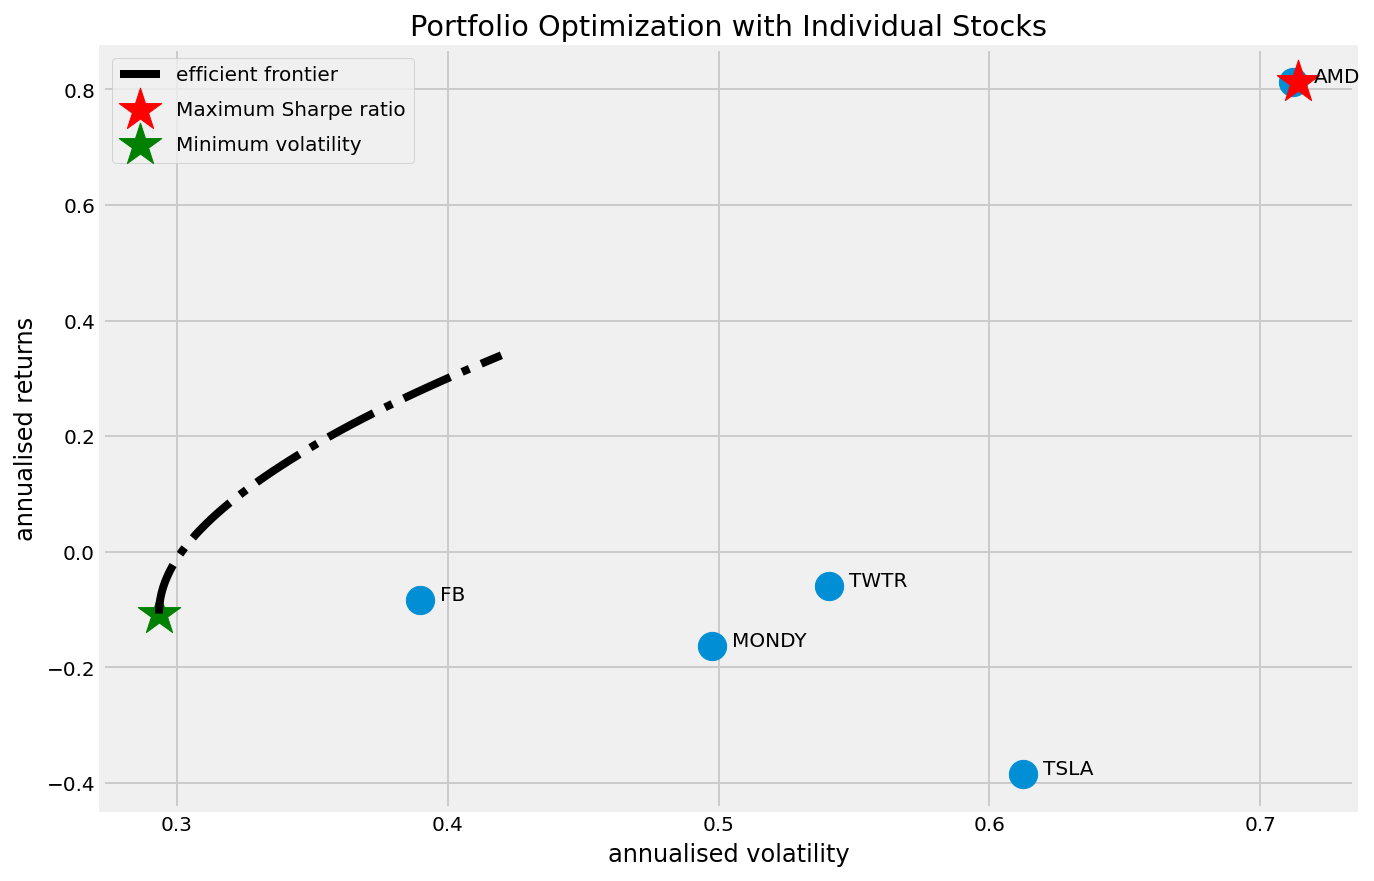

In [18]:
display_ef_with_selected(mean_daily_returns, cov_matrix, risk_free_rate)

As you can see from the above plot, the stock with the least risk is FB at around 0.4. But with portfolio optimisation, we can achieve even lower risk. And if we are willing to take slightly more risk at around the similar level of risk of FB, we can achieve a much higher return of 0.30 with portfolio optimisation.

## Principal Component Analysis (PCA)

One of the first unsupervised learning models you get familiar with at the machine learning class is a [principal component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis). It decomposes multidimensional data into the set of linearly uncorrelated variables, where the first such variable (also called principal component) is explaining the most variation in the data, and all next variables are sorted by having the maximal variance while being orthogonal to the previous variable. How we can use it for portfolio management? Many ideas are published, the [most common](https://srome.github.io/Eigenvesting-I-Linear-Algebra-Can-Help-You-Choose-Your-Stock-Portfolio/) one says that the first principal component serves as an approximation of the market, hence, choosing second and other components will give **uncorrelated to the market** strategies, which is what most of the investors want.

### Eigendecomposition of the returns covariance matrix

We will denote the covariance matrix of the returns over some period as $\Sigma$. The price for an asset $i$ at a given time $t$ is $p_{i,t}$ and returns for each stock $i$ will be written as $r_{i,t}=(p_{i,t}−p_{i,t−1})/p_{i,t−1}$. These returns can be arranged into a matrix and used to find the sample covariance.

We will further define the amount invested in stock $i$ relative to one’s total capital as $w_i$. Positive values in the weight is also called going “long” in a stock. If a weight is negative, that is related to a “short sale”, where you borrow capital to buy the stock. Usually, you “long” (verb) stocks that will increase in value and “short” (verb) stocks that will decrease.

#### Portfolio Theory Fundamentals

If we have a set of stocks $S$ and our chosen weights represented as a vector $w=[w_i]_{i\in S}$, then the pair $(S,w)$ describes a portfolio allocation. This can be used, for instance, in a “buy and hold” strategy for investing. If we had access to the covariance matrix $\Sigma$, then the risk (variance!) of the investing strategy is given by the formula

$$risk=w^T\Sigma w$$

This is an extremely important idea – we have a way to quantify our risk for a given portfolio! Mathematically, this formula lends itself to be used in all sorts of optimization problems, but there’s a very simple one we can point out immediately: If we would like the minimum risk when the weight are of unit length in $L^2$, the weight are simply the eigenvector associated with the smallest eigenvalue and the risk is the smallest eigenvalue. We have just witnessed a powerful connection, and frankly, one of the most approachable applications of eigenvalues and eigenvectors.

#### Introducing Eigenportfolios

Since the covariance matrix is similar by definition to the correlation matrix (in the sense of a linear transformation similarity), the eigenvalues will be the same and the eigenvectors (which we are interested in) have a 1-1 correspondence between them, assuming none of the variances for any of the stocks are equal to 0.

The covariance matrix has some nice properties in the case of stock returns. First of all, it is a symmetric matrix, and so its eigenvalues are positive and its eigenvectors are orthogonal to each other. The typical interpretation of the eigenvalue decomposition of a covariance matrix is this:

- The eigenvalues give the “variance” of each “factor” or eigenvector

- The variance associated with each factor is “uncovariated” with the others (If we use the correlation matrix, this would be uncorrelated.)

I put the words above in quotes because this is meaningless until you connect it to where the matrix came from. Here, we know loosely that each eigenvalue corresponds to the risk of a portfolio and that the eigenvectors can represent an allocation of weights. So in this context, we can make the interpretations

- Eigenvectors are the “eigenportfolios”, strategy weight allocations which are uncorrolated to other eigenportfolios

- Eigenvalues are the “risk” of the given eigenportfolio

#### The Market Eigenvalue

It has been empirically verified that the largest eigenvalue and associated eigenportfolio will correlate strongly with the market, assuming the data you built the matrix with captures the market. Usually, when using this technique in practice, you may want to remove that eigenportfolio so that your returns will be (hopefully) disconnected with the marked.

We can use the correlation matrix from closing stock price data. 

In [19]:
cov_matrix

AMD        FB      TSLA      TWTR     MONDY
AMD    0.002023  0.000266  0.000351  0.000353  0.000149
FB     0.000266  0.000605  0.000172  0.000405  0.000049
TSLA   0.000351  0.000172  0.001496  0.000452 -0.000002
TWTR   0.000353  0.000405  0.000452  0.001166  0.000195
MONDY  0.000149  0.000049 -0.000002  0.000195  0.000988

But typically you would test your algorithms “in sample” and “out of sample”. Therefore, we’re going to take the finance equivalent of a training set and test set.

In [20]:
training_period = 30
in_sample = returns.iloc[:(returns.shape[0]-training_period), :].copy()
covariance_matrix = in_sample.cov()
covariance_matrix

AMD        FB      TSLA      TWTR     MONDY
AMD    0.002247  0.000294  0.000353  0.000372  0.000197
FB     0.000294  0.000657  0.000193  0.000435  0.000040
TSLA   0.000353  0.000193  0.001589  0.000485  0.000017
TWTR   0.000372  0.000435  0.000485  0.001166  0.000170
MONDY  0.000197  0.000040  0.000017  0.000170  0.000944

#### The Eigenvalues of the Covariance Matrix

Let’s extract an eigenportfolio! To avoid the dreaded Market-correlated portfolio (we aren’t trying to build an index fund here!), let’s take a portfolio using the next eigenvector. 

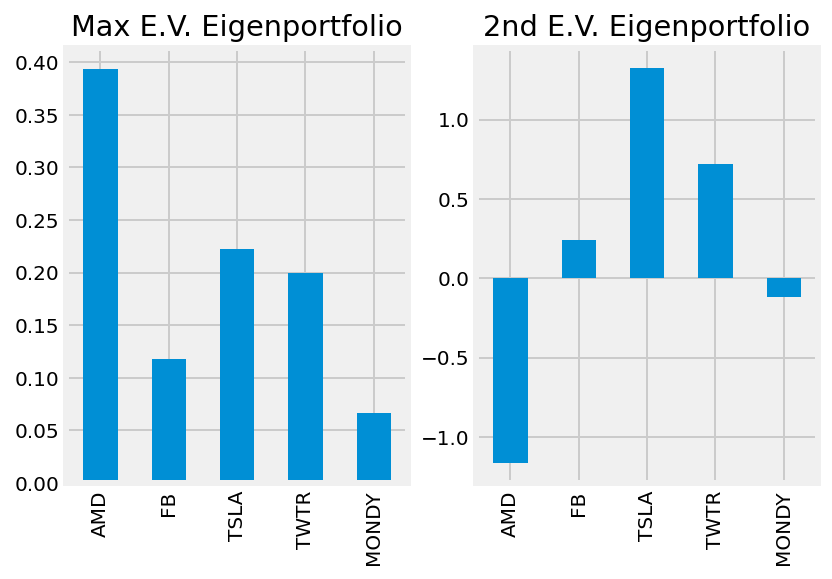

In [21]:
D, S = np.linalg.eigh(covariance_matrix)
eigenportfolio_1 = S[:,-1] / np.sum(S[:,-1]) # Normalize to sum to 1
eigenportfolio_2 = S[:,-2] / np.sum(S[:,-2]) # Normalize to sum to 1


# Setup Portfolios
eigenportfolio1 = pd.DataFrame(data= eigenportfolio_1, columns = ['Investment Weight'], index = data.columns.copy())
eigenportfolio2 = pd.DataFrame(data= eigenportfolio_2, columns = ['Investment Weight'], index = data.columns.copy())
    
# Plot
f = plt.figure()
ax = plt.subplot(121)
eigenportfolio1.plot(kind='bar', ax=ax, legend=False)
plt.title("Max E.V. Eigenportfolio")
ax = plt.subplot(122)
eigenportfolio2.plot(kind='bar', ax=ax, legend=False)
plt.title("2nd E.V. Eigenportfolio")
plt.show()

This is a typical chart for visualizing an allocation strategy. Each bar indicates the weight associated with a stock and the tickers are arranged in alphabetical order. These two portfolios are supposed to have uncorrolated returns, and possibly in large part, because of their different treatment of AMD. Of course, we could calculate the expected risk or returns for this portfolio, but it would be more fun to see it in action!

### Visualizing the Results

At this point, we are ready to see how our modest strategy will perform on real data. However, the caveat is the short sale, or the negative weight we found for AMD and MONDY. Short selling would require more logic built into a simulation and it’s not very instructive, so instead we’re going to zero out that weight and renormalize.

#### In Sample vs. Out of Sample

In machine learning speak, we are really interested in our performance on the test set, but are happy to know a little about the performance on the training set. To do this, we’re going to plot our culmulative returns over time in the out of sample period.

Culmulative returns at time $t$ is given by $CR_t=\prod_{i=0}^t(1+r_i)−1$ where $r_i$ is the return of the period. This will allow us to visualize the performance of the algorithms better over time.

Again, to avoid issues around short sales, I am going to use the portfolio without them.

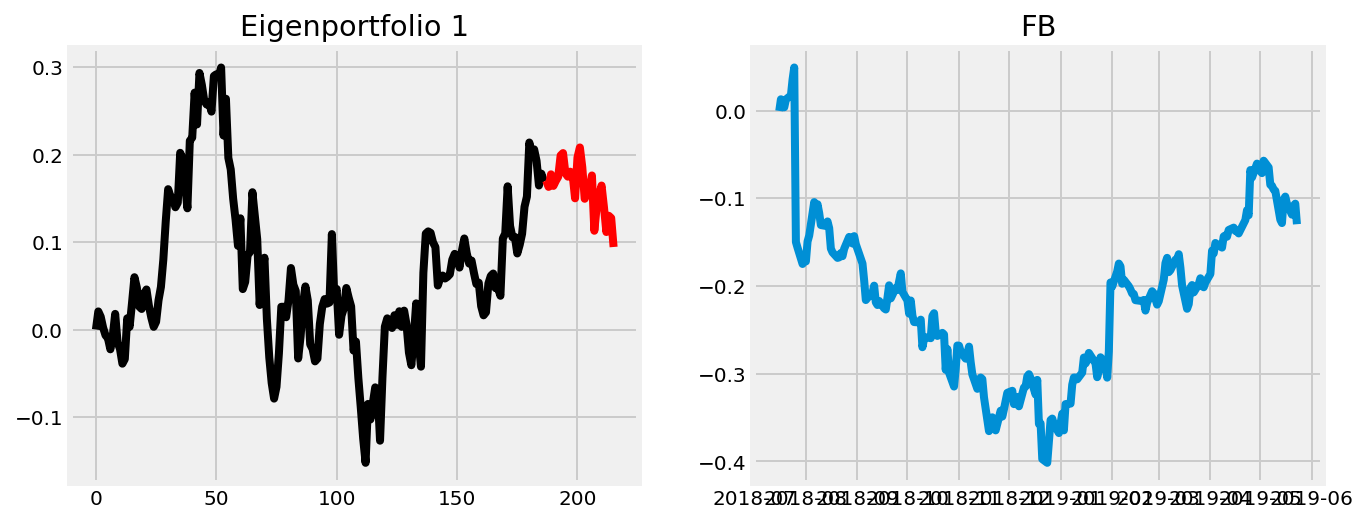

In [22]:
def get_cumulative_returns_over_time(sample, weights):
        return (((1+sample).cumprod(axis=0))-1).dot(weights)
    
in_sample_ind = np.arange(0, (returns.shape[0]-training_period+1))
out_sample_ind = np.arange((returns.shape[0]-training_period+1), returns.shape[0])
    
cumulative_returns = get_cumulative_returns_over_time(returns, 
                                                      eigenportfolio1).values
        
f = plt.figure(figsize=(10,4))
ax = plt.subplot(121)
ax.plot(cumulative_returns[in_sample_ind], 'black')
ax.plot(out_sample_ind,cumulative_returns[out_sample_ind], 'r')
plt.title("Eigenportfolio 1")
    
ax = plt.subplot(122)
plt.plot((((1+returns.loc[:,'FB']).cumprod(axis=0))-1))
plt.title("FB")
plt.show()

As you can see, the black is our “in sample” performance and the red is our “out of sample”. If we compare this to FB during the same time period, you’ll see that we, in fact, did much better and avoided some of the volatility of FB. Of course, we’re using what would be the “Market Mode” if we had more stocks included, and so it’s also the riskiest eigenportfolio, as it related to the highest eigenvalue.

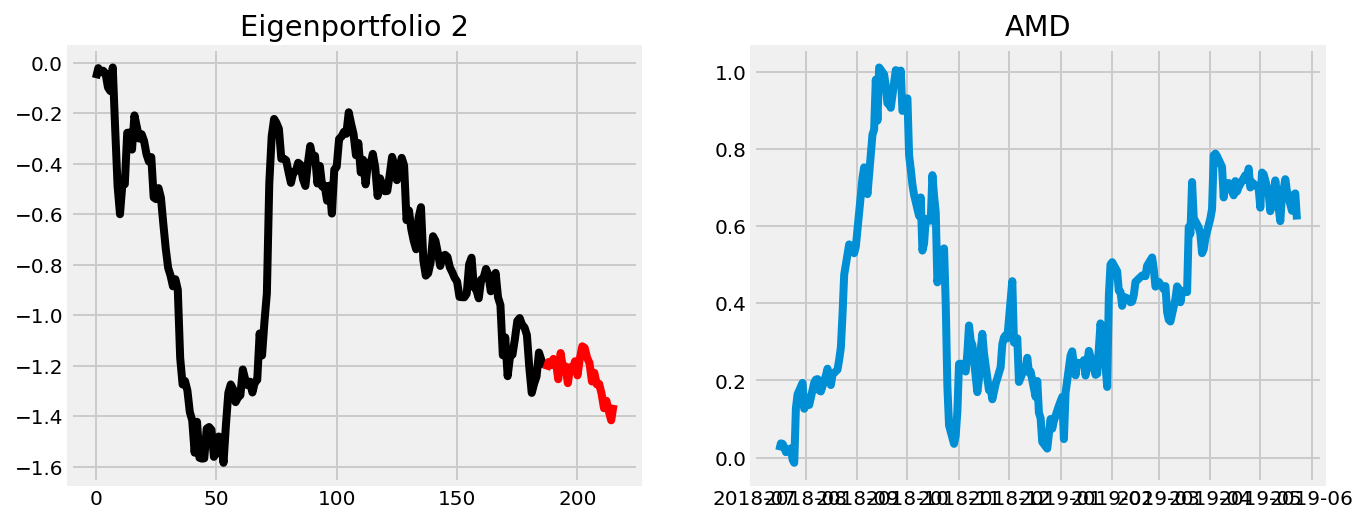

In [23]:
cumulative_returns = get_cumulative_returns_over_time(returns, 
                                                      eigenportfolio2).values

f = plt.figure(figsize=(10,4))
ax = plt.subplot(121)
ax.plot(cumulative_returns[in_sample_ind], 'black')
ax.plot(out_sample_ind,cumulative_returns[out_sample_ind], 'r')
plt.title("Eigenportfolio 2")
    
ax = plt.subplot(122)
plt.plot((((1+returns.loc[:,'AMD']).cumprod(axis=0))-1))
plt.title("AMD")
plt.show()

Eigenportfolio 2 is clearly anti-correlated to AMD.

## Risk Parity

[Risk parity](https://thequantmba.wordpress.com/2016/12/14/risk-parityrisk-budgeting-portfolio-in-python/) is a classic approach for portfolio construction in finance. The basic idea is to make sure the risk contribution for each asset is equal.

First define the **marginal risk contribution** as:

$$MRC_j = \frac{\partial\sigma_p}{\partial w_j}=\frac{(V*w)_j}{\sigma_p}$$

where $w_i$ are the weights of asset $i$,  $\sigma_p=\sqrt{wVw^T}$ the portfolio risk, and $V$ the covariance matrix. 

Then, the **risk contribution of asset $j$** to the total portfolio is:

$$RC_j = w * MRC_j = \frac{w_j(V*w)_j}{\sigma_p}$$

Risk Parity portfolio is a portfolio which RC are equal across all individual assets.

Let the sum of squared error of a portfolio assets RC  be:

$$J(x) = \sum_{i=1}^n \sum_{j=1}^n (w_i(V*w)_i -w_i(V*w)_j)^2$$

Then

$$\min J(x)$$
$$s.t.\sum_i w_i = 1, 0\le w_i \le 1$$


In [24]:
def calculate_portfolio_var(w,V):
    # function that calculates portfolio risk
    w = np.matrix(w)
    return (w*V*w.T)[0,0]

def calculate_risk_contribution(w,V):
    # function that calculates asset contribution to total risk
    w = np.matrix(w)
    sigma = np.sqrt(calculate_portfolio_var(w,V))
    # Marginal Risk Contribution
    MRC = V*w.T
    # Risk Contribution
    RC = np.multiply(MRC,w.T)/sigma
    return RC

def risk_budget_objective(x,pars):
    # calculate portfolio risk
    V = pars[0]# covariance table
    x_t = pars[1] # risk target in percent of portfolio risk
    x = np.matrix(x)
    sig_p =  np.sqrt(calculate_portfolio_var(x,V)) # portfolio sigma
    risk_target = np.asmatrix(np.multiply(sig_p,x_t))
    asset_RC = calculate_risk_contribution(x,V)
    J = sum(np.square(asset_RC-risk_target.T))[0,0] # sum of squared error
    return J

def total_weight_constraint(x):
    return np.sum(x)-1.0

def long_only_constraint(x):
    return x

In [25]:
n=cov_matrix.shape[0]
# your risk budget percent of total portfolio risk (equal risk)
x_t= np.ones(n)/n
w0 = np.ones(n)/n
V = np.matrix(cov_matrix)
cons = ({'type': 'eq', 'fun': total_weight_constraint},
        {'type': 'ineq', 'fun': long_only_constraint})
res= sco.minimize(fun=risk_budget_objective, 
                  x0=w0, 
                  args=[V,x_t], 
                  method='SLSQP',
                  constraints=cons, 
                  tol=TOLERANCE,
                  options={'disp': True})
w_rb = np.asmatrix(res.x)
np.squeeze(np.asarray(calculate_risk_contribution(w_rb,V)))

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.346651957634623e-09
            Iterations: 26
            Function evaluations: 156
            Gradient evaluations: 26


array([0.00396142, 0.00393439, 0.00400829, 0.00392976, 0.00398223])

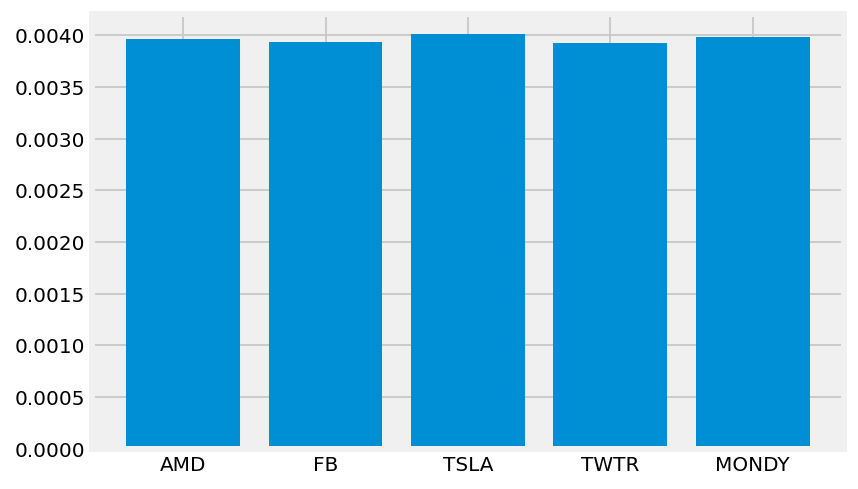

In [26]:
fig, ax = plt.subplots()
x = np.arange(n)
plt.bar(x, np.squeeze(np.asarray(calculate_risk_contribution(w_rb,V))))
plt.xticks(x, data.columns)
plt.show()

In [27]:
import riskparityportfolio as rp
optimum_weights = rp.vanilla.design(V, x_t)
optimum_weights

array([0.14881563, 0.25743658, 0.17913118, 0.16425521, 0.25036139])

In [28]:
#fig, ax = plt.subplots()
#x = np.arange(n)
#plt.bar(x, np.squeeze(np.asarray(calculate_risk_contribution(optimum_weights,V))))
#plt.xticks(x, data.columns)
#plt.show()

## Autoencoders

One of the alternatives, that allows non-linear dimensionality reduction, is based on neural networks — autoencoders. They can “squeeze” input data into some low-dimensional vector and after restore input from this representation. The idea of autoencoder can be exploited in [many ways](https://arxiv.org/pdf/1605.07230.pdf) for portfolio selection, one of them is related to the evaluation of the risk carried by the particular asset: if some asset movement can’t be restored well (the predicted value differs a lot from the input in terms of, let’s say, mean squared error) from the low-dimensional representation — it’s associated with higher risk (and, possibly, higher profits). 



The following code builds a simple linear autoencoder (linear activation, MSE cost function) to perform PCA on the asset returns.

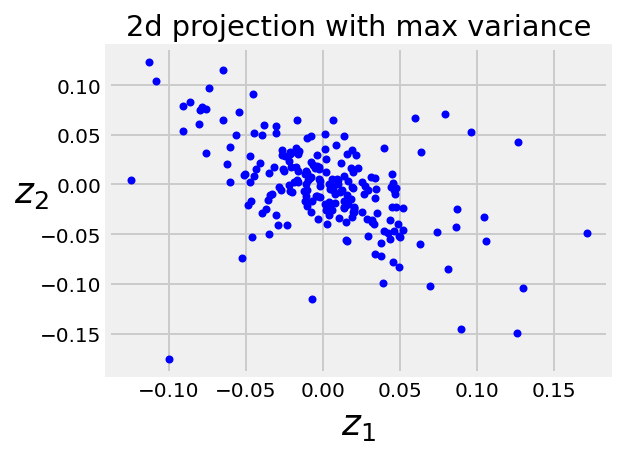

In [29]:
num_assets = len(data.columns)
num_hidden = 2
num_epochs = 1000
encoder = keras.models.Sequential([keras.layers.Dense(num_hidden, input_shape=[num_assets])])
decoder = keras.models.Sequential([keras.layers.Dense(num_assets, input_shape=[num_hidden])])
autoencoder = keras.models.Sequential([encoder,decoder])
autoencoder.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss="mse")
# train on returns
history = autoencoder.fit(returns,returns,verbose=0,epochs=num_epochs)
codings = encoder.predict(returns)
# show the best 2D-plane to project the data on, 
# preserving as much variance in the data as it could
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.title("2d projection with max variance")
plt.grid(True)
plt.show()

The goal however is to detect anomalies in the data. The assumption is, that complex patterns in the data can not be well reproduced in the decoder. So, there will be some difference between input and output of the trained model. This difference is bad news for investors and they will set the weights acordingly. 

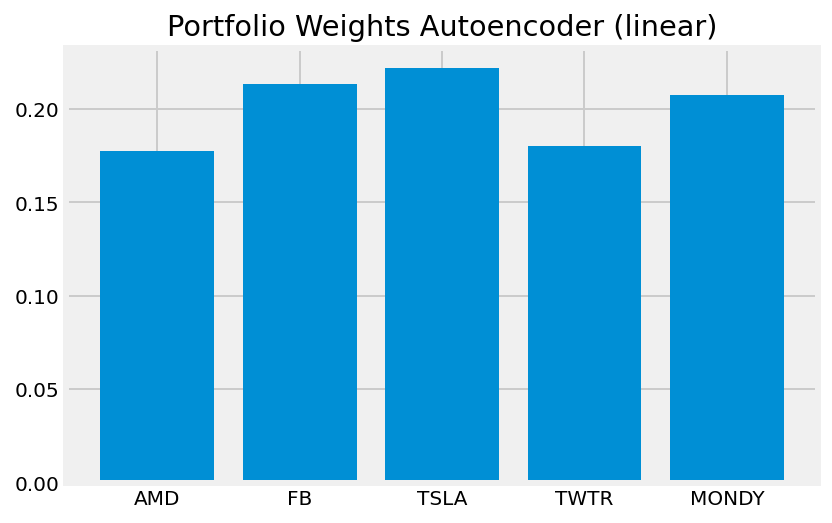

array([0.17757817, 0.21356226, 0.22165783, 0.17991094, 0.20729079])

In [30]:
def get_optimal_weights(returns, autoencoder):
        data = returns
        autoencoder.fit(data, data, shuffle=False, epochs=25, batch_size=32, verbose=False)
        reconstruct = autoencoder.predict(data)

        communal_information = []

        for i in range(0, len(returns.columns)):
            diff = np.linalg.norm((returns.iloc[:,i] - reconstruct[:,i])) # 2 norm difference
            communal_information.append(float(diff))

        optimal_weights = np.array(communal_information) / sum(communal_information)

        if False: # don't allow shortselling
            optimal_weights /= sum(np.abs(optimal_weights))
        else:
            optimal_weights += np.abs(np.min(optimal_weights))
            optimal_weights /= sum(optimal_weights)
            
        return optimal_weights
# get weights
optimal_weights = get_optimal_weights(returns,autoencoder)
fig, ax = plt.subplots()
x = np.arange(num_assets)
plt.bar(x, optimal_weights)
plt.xticks(x, data.columns)
plt.title('Portfolio Weights Autoencoder (linear)')
plt.show()
optimal_weights_ael = optimal_weights
optimal_weights

The following code builds a simple non-linear autoencoder to rank the portfolio weights according decreasing reproducibility of the asset returns.

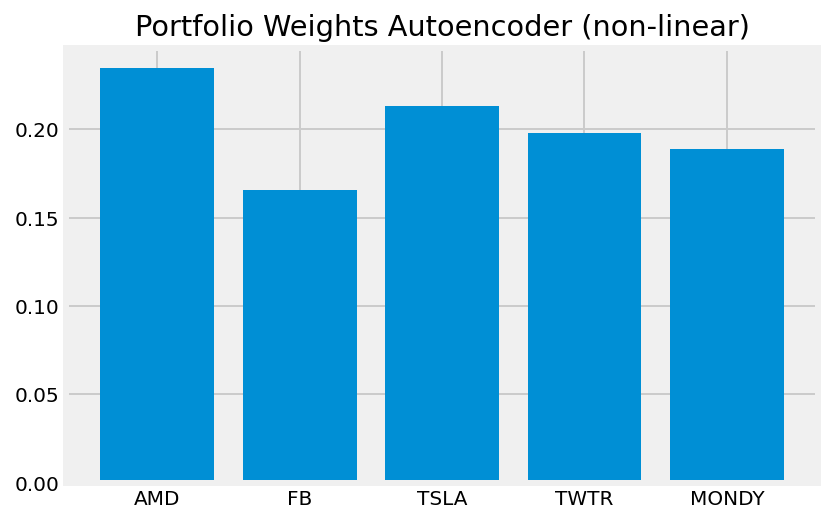

array([0.23438824, 0.16577702, 0.21316691, 0.19792067, 0.18874717])

In [31]:
input_img = keras.layers.Input(shape=(num_assets, ))
encoded = keras.layers.Dense(num_hidden, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-6))(input_img)
decoded = keras.layers.Dense(num_assets, activation= 'linear', kernel_regularizer=keras.regularizers.l2(1e-6))(encoded)
autoencoder = keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
# train on returns
history = autoencoder.fit(returns,returns,verbose=0,epochs=num_epochs)
# get weights
optimal_weights = get_optimal_weights(returns,autoencoder)
fig, ax = plt.subplots()
x = np.arange(num_assets)
plt.bar(x, optimal_weights)
plt.xticks(x, data.columns)
plt.title('Portfolio Weights Autoencoder (non-linear)')
plt.show()
optimal_weights_aen = optimal_weights
optimal_weights

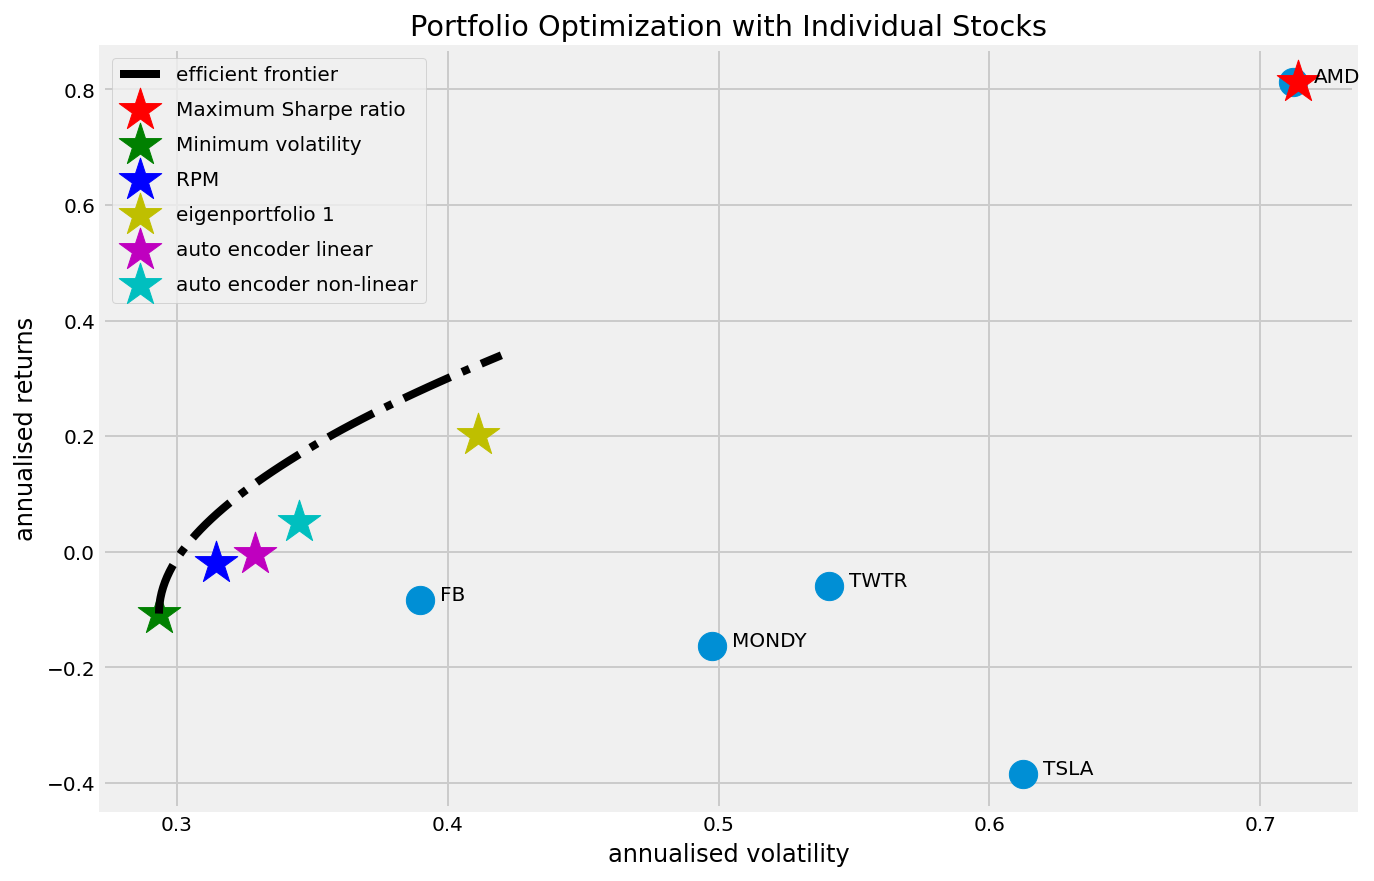

In [32]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    min_vol    = min_variance(mean_returns, cov_matrix)
    sdp, rp         = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    sdp_rpm, rp_rpm = portfolio_annualised_performance(optimum_weights, mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    sdp_eig1, rp_eig1 = portfolio_annualised_performance(np.squeeze(np.asarray(eigenportfolio1.to_numpy())), mean_returns, cov_matrix)
    sdp_eig2, rp_eig2 = portfolio_annualised_performance(np.squeeze(np.asarray(eigenportfolio2.to_numpy())), mean_returns, cov_matrix)
    sdp_ael, rp_ael = portfolio_annualised_performance(optimal_weights_ael, mean_returns, cov_matrix)
    sdp_aen, rp_aen = portfolio_annualised_performance(optimal_weights_aen, mean_returns, cov_matrix)
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
        
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(data.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp     ,rp     ,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min ,rp_min ,marker='*',color='g',s=500, label='Minimum volatility')
    ax.scatter(sdp_rpm ,rp_rpm ,marker='*',color='b',s=500, label='RPM')
    ax.scatter(sdp_eig1,rp_eig1,marker='*',color='y',s=500, label='eigenportfolio 1')
    #ax.scatter(sdp_eig2,rp_eig2,marker='*',color='k',s=500, label='eigenportfolio 2')
    ax.scatter(sdp_ael,rp_ael,marker='*',color='m',s=500, label='auto encoder linear')
    ax.scatter(sdp_aen,rp_aen,marker='*',color='c',s=500, label='auto encoder non-linear')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)
display_ef_with_selected(mean_daily_returns, cov_matrix, risk_free_rate)